In [8]:
import qiskit
import matplotlib.pyplot as plt

from qiskit.visualization import *
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.result import marginal_counts
import numpy as np

# Step 1: Creating the Bell pair

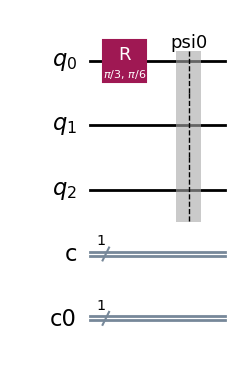

In [9]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

# Create quantum and classical registers
qreg_q = QuantumRegister(3, 'q')
creg_c = ClassicalRegister(1, 'c')
creg_c0 = ClassicalRegister(1, 'c0')

# Create quantum circuit
circuit = QuantumCircuit(qreg_q, creg_c, creg_c0)

#state we wish to teleport
theta=np.pi/3
phi=np.pi/6
circuit.r(theta,phi,0)
circuit.save_statevector(label='psi0')
# we save the initial state so that we can easily check at the end that the
circuit.draw('mpl')

**Task** create a Bell pair shared by q1 and q2 and display the circuit

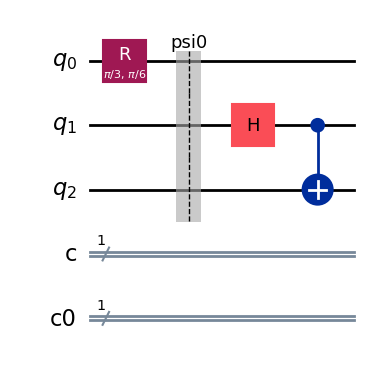

In [10]:
circuit.h(qreg_q[1]) 
circuit.cx(qreg_q[1], qreg_q[2])

circuit.draw('mpl')

<details>
 <summary><b> Click to see solution </b> </summary>
    
    ```python
circuit.h(qreg_q[1])
circuit.cx(qreg_q[1], qreg_q[2])

# Draw the circuit
circuit.draw('mpl')
    ```
</details>

# Step 2: Alice perform a Bell State Measurement

**Task** 
- Entangle the data qubit q0 with q1. Rotate q0 in the basis for Pauli-X. 
- Measure q0 and q1 and encode the result onto the classical qubits
- Display the circuit

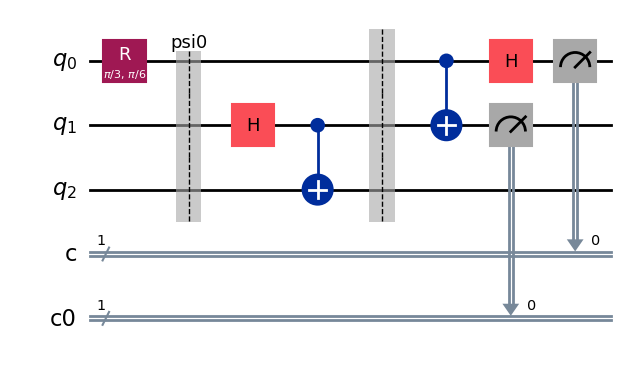

In [11]:
#Entangle data qubit q0 with Alice's qubit of the Bell pair
circuit.barrier(qreg_q)
circuit.cx(qreg_q[0], qreg_q[1])
circuit.h(qreg_q[0])

#Measure
circuit.measure(qreg_q[0], creg_c[0])
circuit.measure(qreg_q[1], creg_c0[0])

# Draw the circuit
circuit.draw('mpl')

<details>
    <summary><b>Click to see solution</b></summary>

```python

#Entangle data qubit q0 with Alice's qubit of the Bell pair
circuit.barrier(qreg_q)
circuit.cx(qreg_q[0], qreg_q[1])
circuit.h(qreg_q[0])

#Measure
circuit.measure(qreg_q[0], creg_c[0])
circuit.measure(qreg_q[1], creg_c0[0])

# Draw the circuit
circuit.draw('mpl')

```
    
</details>

# Step 4: Alice calls Bob up

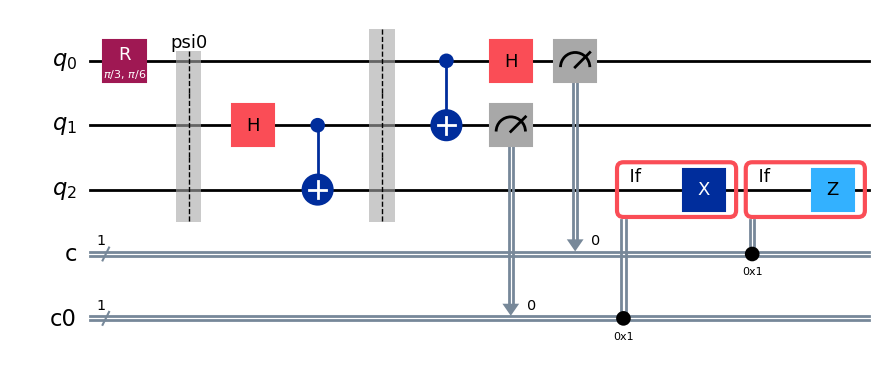

In [12]:
#circuit.x(qreg_q[2]).c_if(creg_c0, 1)

with circuit.if_test((creg_c0, 1)) :
    circuit.x(qreg_q[2])

with circuit.if_test((creg_c, 1)) :
    circuit.z(qreg_q[2])

#circuit.z(qreg_q[2]).c_if(creg_c, 1)

display(circuit.draw('mpl'))

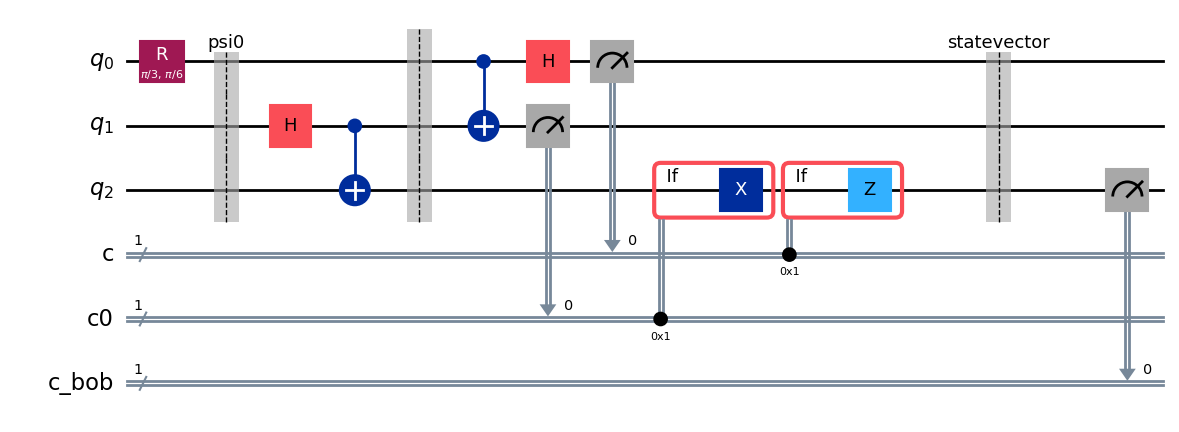

In [13]:
creg_c_bob = ClassicalRegister(1, 'c_bob')
circuit.save_statevector()
circuit.add_register(creg_c_bob)

circuit.measure(qreg_q[2], creg_c_bob)

circuit.draw('mpl')

# Check Bob's qubit

{'1': 271, '0': 753}


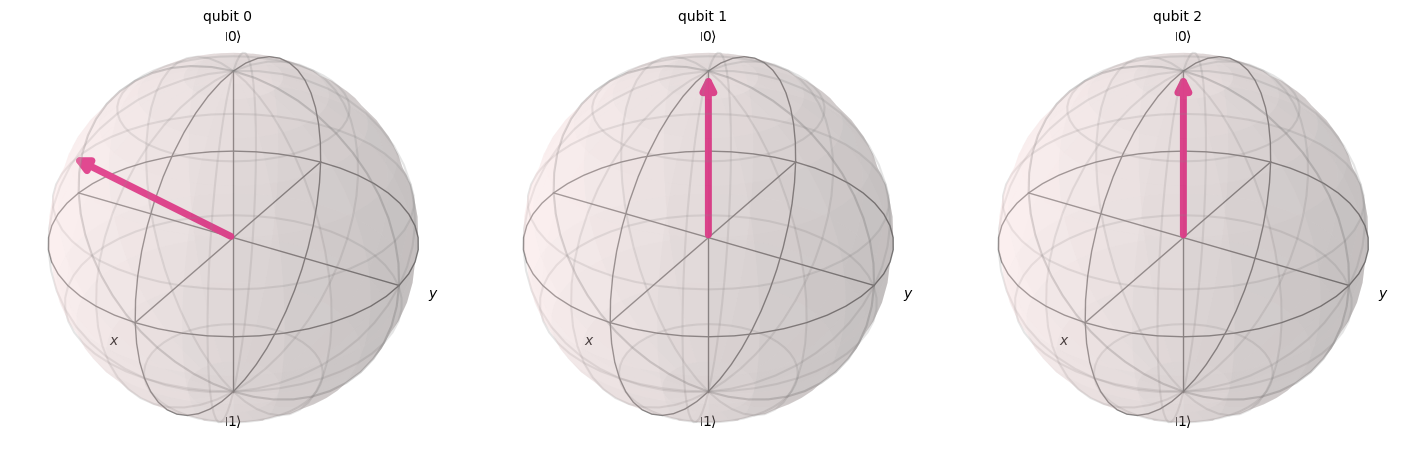

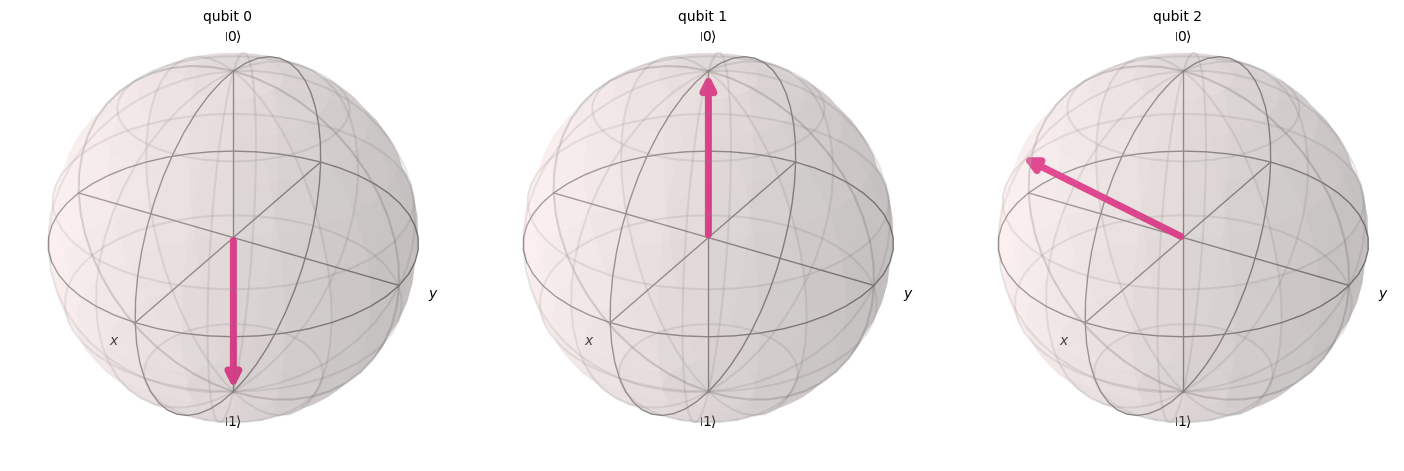

In [14]:
simulator = AerSimulator(method='statevector')
#compiled_circuit = transpile(circuit, simulator)
job = simulator.run(circuit)
result = job.result()
counts = result.get_counts()

psi = result.get_statevector(circuit)
marginal_result = marginal_counts(result.get_counts(), indices=[2])
print(marginal_result)
#display(plot_histogram(marginal_result))

psi_0=result.data(circuit)['psi0']

display(plot_bloch_multivector(psi_0))
plot_bloch_multivector(psi)

# If time allows we can talk about information flow, see the detector as a quantum device and how information flows through the quantum channel

## https://arxiv.org/pdf/2304.14959

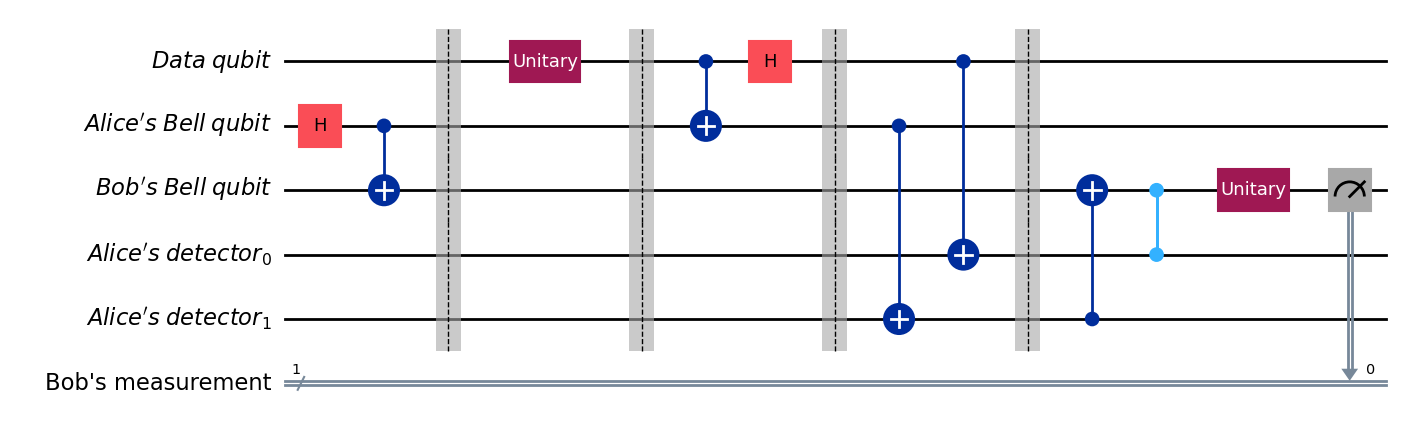

In [15]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.quantum_info import random_unitary

# Define quantum registers and classical registers
data_q = QuantumRegister(1, "Data qubit")
alice_q = QuantumRegister(1, "Alice's Bell qubit")
bob_q = QuantumRegister(1, "Bob's Bell qubit")
bob_c = ClassicalRegister(1, "Bob's measurement")

# Create a QuantumCircuit
qc = QuantumCircuit(data_q, alice_q, bob_q, bob_c)

# Generate a random unitary operation
U = random_unitary(2)
U_gate = U.to_instruction()
U_dagger_gate = U.adjoint().to_instruction()

# Add the new quantum registers
alice_detector_q = QuantumRegister(2, "Alice's detector")
qc.add_register(alice_detector_q)

# Apply the operations as described
qc.h(alice_q[0])
qc.cx(alice_q[0], bob_q[0])
qc.barrier()
qc.append(U_gate, [data_q[0]])
qc.barrier()
qc.cx(data_q[0], alice_q[0])
qc.h(data_q[0])
qc.barrier()
qc.cx(alice_q[0], alice_detector_q[1])
qc.cx(data_q[0], alice_detector_q[0])
qc.barrier()
qc.cx(alice_detector_q[1], bob_q[0])
qc.cz(alice_detector_q[0], bob_q[0])
qc.append(U_dagger_gate, [bob_q[0]])
qc.measure(bob_q[0], bob_c[0])

# Draw the complete circuit
qc.draw('mpl')

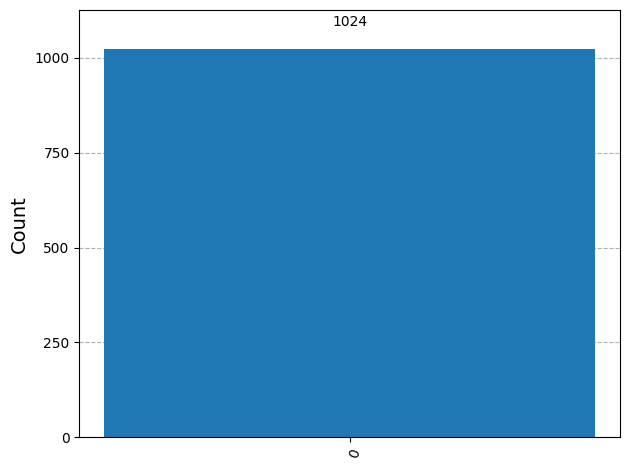

In [16]:
compiled_circuit = transpile(qc, simulator)
job = simulator.run(compiled_circuit)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)